In [39]:
ensurePackage <- function(packageName) {
  if (!require(packageName, character.only = TRUE, quietly = TRUE)) {
    install.packages(packageName, dependencies = TRUE, quietly = TRUE)
    library(packageName, character.only = TRUE)
  }
}


ensurePackage("httr")
ensurePackage("jsonlite")

# Helper function to get interpretation from OpenAI
get_interpretation <- function(test_results) {
  api_key <- Sys.getenv("OPENAI_API_KEY")
  endpoint <- "https://api.openai.com/v1/engines/davinci-codex/completions"
  prompt <- paste("Here are the statistical test results:\n", test_results, "\nPlease provide an interpretation and suggest next steps.")

  response <- httr::POST(
    endpoint,
    httr::add_headers(`Content-Type` = "application/json", `Authorization` = paste("Bearer", api_key)),
    body = jsonlite::toJSON(list(prompt = prompt, max_tokens = 150), auto_unbox = TRUE)
  )

  interpretation <- httr::content(response)$choices[[1]]$text
  return(interpretation)
}
#' catrecode: Recode Categorical Variables in a Data Frame
#'
#' This function takes a data frame and automatically recodes all character and factor
#' columns. It is particularly useful for preparing categorical data for machine learning
#' models. The function performs the following steps:
#'
#' 1. Checks for and installs/loads the 'caret' package.
#' 2. Identifies all character and factor columns in the data frame.
#' 3. Converts factor columns to character columns for consistent processing.
#' 4. Removes character columns with more than 50 unique values to avoid excessive
#'    dummy variable creation.
#' 5. Recodes "Yes" and "No" values to 1 and 0, respectively.
#' 6. Recodes remaining categorical levels to numeric values, starting from 0 or 2,
#'    depending on the presence of "Yes"/"No" recodings.
#' 7. Converts recoded character columns back to numeric.
#' 8. Stores a summary of the recoding in a global variable 'RecodeTable'.
#' 9. Assigns the recoded data frame to a global variable 'recoded_df'.
#' 10. Provides a function 'catcode1' to print the recoding summary.
#'
#' @param data A data frame with categorical variables to be recoded.
#'
#' @return The function invisibly returns the recoded data frame and also assigns it to
#'         the global variable 'recoded_df'. The recoding summary is stored in the global
#'         variable 'RecodeTable' and can be printed using 'catcode1'.
#'
#' @examples
#' data(iris)
#' recoded_iris <- catrecode(iris)
#' catcode1()  # Print the recoding summary
#'
#' @note This function modifies the global environment by adding 'recoded_df' and
#'       'RecodeTable'. It is designed for interactive use. For programming purposes,
#'       consider modifying the function to return a list containing the recoded data
#'       and the recoding summary.
#'
#' @export

catrecode <- function(data) {
  if(!require(caret, quietly = TRUE)){
    install.packages("caret", quiet = TRUE)
    library(caret, quietly = TRUE)
  }

  # Identify character and factor columns
  cat_col_names <- names(data)[sapply(data, function(x) is.character(x) | is.factor(x))]

  # If there are no categorical columns, return the data as is
  if(is.null(cat_col_names) || length(cat_col_names) == 0) {
    cat("No character or factor columns found for recoding.\n")
    return(data)
  }

  # Convert factor columns to character columns for processing
  factor_cols <- names(data)[sapply(data, is.factor)]
  data[factor_cols] <- lapply(data[factor_cols], as.character)

  # Identify and remove character columns with more than 50 unique values
  excessive_unique_names <- cat_col_names[sapply(data[cat_col_names], function(col) length(unique(col)) > 50)]

  if(length(excessive_unique_names) > 0) {
    cat("Columns with more than 50 unique values removed:\n", paste(excessive_unique_names, collapse = " "), "\n\n")
    data <- data[, !names(data) %in% excessive_unique_names]
  }

  # Updated list of character columns after removal
  cat_col_names <- setdiff(cat_col_names, excessive_unique_names)

  # Create an empty list to store the recoding summary
  recoding_summary <- list()

  # Iterate through the identified character columns
  for(col_name in cat_col_names) {
    unique_vals <- unique(data[[col_name]])
    recode_pairs <- list()

    # Handle "Yes" and "No" recoding first and exclude them from the subsequent processing
    if("Yes" %in% unique_vals) {
      recode_pairs["Yes"] <- "1"
      data[data[[col_name]] == "Yes", col_name] <- "1"
      unique_vals <- setdiff(unique_vals, "Yes")
    }
    if("No" %in% unique_vals) {
      recode_pairs["No"] <- "0"
      data[data[[col_name]] == "No", col_name] <- "0"
      unique_vals <- setdiff(unique_vals, "No")
    }

    # Recode the remaining levels
    new_level <- 0
    for(level in unique_vals) {
      if (new_level == 0 && ("0" %in% recode_pairs || "1" %in% recode_pairs)) {
        new_level <- 2
      } else if (new_level == 1 && "1" %in% recode_pairs) {
        new_level <- 2
      }

      recode_pairs[level] <- as.character(new_level)
      data[data[[col_name]] == level, col_name] <- as.character(new_level)
      new_level <- new_level + 1
    }

    data[[col_name]] <- as.numeric(as.character(data[[col_name]]))
    recoding_summary[[col_name]] <- recode_pairs
  }

  # Store the recoding summary in the global variable "RecodeTable"
  assign("RecodeTable", recoding_summary, envir = .GlobalEnv)

  # Report on the recoding
  cat("Recoding Report:\n")
  for(col_name in names(recoding_summary)) {
    pairs <- recoding_summary[[col_name]]
    cat(col_name, ": ", paste(paste(names(pairs), "->", unlist(pairs)), collapse = ", "), "\n")
  }
  cat("\n")

  # Assign the recoded data to global variable "recoded_df"
  assign("recoded_df", data, envir = .GlobalEnv)

  # Function to print the recoding summary
  printRecodingReport <- function() {
    if(exists("RecodeTable", envir = .GlobalEnv)) {
      cat("Recoding Report:\n")
      for(col_name in names(RecodeTable)) {
        pairs <- RecodeTable[[col_name]]
        cat(col_name, ": ", paste(paste(names(pairs), "->", unlist(pairs)), collapse = ", "), "\n")
      }
      cat("\n")
    } else {
      cat("No recoding report available.\n")
    }
  }

  # Remove existing 'catcode1' if it exists
  if(exists("catcode1", envir = globalenv())) {
    rm(catcode1, envir = globalenv())
  }

  # Use active binding to assign the function to 'catcode1'
  makeActiveBinding("catcode1", function() printRecodingReport(), env = globalenv())

  invisible(data)
}

#' catclean: Clean and Recode Data Frame
#'
#' This function cleans and recodes a data frame. It performs the following steps:
#' 1. Recodes character and factor columns using 'catrecode'.
#' 2. Identifies and removes columns with zero or near-zero variance.
#' 3. Identifies and removes rows with missing data.
#' 4. Identifies highly correlated variables and prints a report.
#'
#' @param data A data frame to be cleaned.
#' @param correlation_threshold A numeric value for the correlation threshold. Defaults to 0.7.
#'
#' @return The cleaned data frame is invisibly returned and assigned to the global variable 'cleaned_df'.
#'
#' @examples
#' data(iris)
#' cleaned_iris <- catclean(iris)
#' catclean1()  # Print the cleaning summary
#'
#' @note This function modifies the global environment by adding 'cleaned_df' and other variables.
#'       It is designed for interactive use.
#'
#' @export

catclean <- function(data, correlation_threshold = 0.7) {
  packages <- c("caret", "igraph", "reshape2", "visdat")
  new_packages <- packages[!(packages %in% installed.packages()[,"Package"])]
  if(length(new_packages)) install.packages(new_packages, quiet = TRUE)
  lapply(packages, require, character.only = TRUE, quietly = TRUE)

  data <- catrecode(data)

  if (!(is.data.frame(data) && nrow(data) > 0 && ncol(data) > 0)) {
    cat("Data is not in the expected format or is empty.\n")
    return(invisible(NULL))
  }

  nzv_indices <- nearZeroVar(data, saveMetrics = TRUE)
  zero_var_cols <- names(data)[nzv_indices$zeroVar]
  near_zero_var_cols <- names(data)[nzv_indices$nzv]

  zeroVarianceReport <- capture.output({
    if(length(zero_var_cols) > 0){
      data <- data[, -which(names(data) %in% zero_var_cols)]
      cat("\nZero Variance Variable Report:\n")
      cat(paste(zero_var_cols, collapse = ", "), "\n")
    } else {
      cat("\nNo columns with zero variance.\n")
    }
  })

  nearZeroVarianceReport <- capture.output({
    if(length(near_zero_var_cols) > 0) {
      cat("\nNear Zero Variance Report:\n")
      cat(paste(near_zero_var_cols, collapse = ", "), "\n")
    } else {
      cat("\nNo columns with near-zero variance.\n")
    }
  })

  rows_with_na <- apply(data, 1, function(row) any(is.na(row)))
  missing_data_rows <- data[rows_with_na, ]
  data <- na.omit(data)

  missingDataReport <- capture.output({
    if(nrow(missing_data_rows) > 0) {
      cat("\nMissing Data Report:\n")
      cat("Row Number\tVariables with Missing Data\n")
      cat(strrep("-", 50), "\n")
      for(row in 1:nrow(missing_data_rows)) {
        missing_vars <- names(missing_data_rows)[apply(is.na(missing_data_rows[row, , drop = FALSE]), 2, any)]
        cat(which(rows_with_na)[row], "\t", paste(missing_vars, collapse = ", "), "\n")
      }
    } else {
      cat("\nNo rows with missing data.\n")
    }
  })

  correlation_matrix <- cor(data, method = "pearson", use = "pairwise.complete.obs")
  highCorrelationReport <- capture.output({
    high_correlations <- which(abs(correlation_matrix) > correlation_threshold & correlation_matrix != 1 & lower.tri(correlation_matrix), arr.ind = TRUE)
    if (length(high_correlations) > 0) {
      cat("\nHighly Correlated Variables Report:\n")
      cat("Variable 1", "Variable 2", "Correlation\n")
      cat(strrep("-", 50), "\n")
      for(i in 1:nrow(high_correlations)) {
        cat(names(data)[high_correlations[i, "row"]], names(data)[high_correlations[i, "col"]],
            round(correlation_matrix[high_correlations[i, "row"], high_correlations[i, "col"]], 4), "\n")
      }
    } else {
      cat("\nNo highly correlated variables found above the threshold.\n")
    }
  })

  plotCorrelatedClusters <- function(data, threshold) {
    correlation_matrix <- cor(data, method = "pearson", use = "pairwise.complete.obs")
    abs_corr_matrix <- abs(correlation_matrix)
    adj_matrix <- abs_corr_matrix > threshold & abs_corr_matrix != 1

    graph <- graph.adjacency(adj_matrix, mode = "undirected")
    clusters <- clusters(graph)

    par(mfrow = c(1, 2))

    plot(graph, main = "Correlated Variable Clusters", vertex.label = V(graph)$name, vertex.size = 10, edge.width = E(graph)$weight, layout = layout_with_kk)

    plot(correlation_matrix, main = "Correlation Matrix Heatmap", col = colorRampPalette(c("blue", "white", "red"))(20))
  }

  plotCorrelatedClusters(data, correlation_threshold)

  assign("catclean_data", data, envir = .GlobalEnv)
  assign("catclean_threshold", correlation_threshold, envir = .GlobalEnv)

  printReportsAndPlot <- function() {
    data <- get("catclean_data", envir = .GlobalEnv)
    threshold <- get("catclean_threshold", envir = .GlobalEnv)

    cat(zeroVarianceReport, sep = "\n")
    cat(nearZeroVarianceReport, sep = "\n")
    cat(missingDataReport, sep = "\n")
    cat(highCorrelationReport, sep = "\n")

    plotCorrelatedClusters(data, threshold)
  }

  if(exists("catclean1", envir = globalenv())) {
    rm(catclean1, envir = globalenv())
  }

  makeActiveBinding("catclean1", function() printReportsAndPlot(), env = globalenv())

  cleaned_df <- data
  assign("cleaned_df", cleaned_df, envir = globalenv())

  if (!requireNamespace("visdat", quietly = TRUE)) {
    install.packages("visdat", quiet = TRUE)
    library(visdat, quietly = TRUE)
  }

  catcleanplot1 <- vis_dat(df)
  catcleanplot2 <- vis_dat(cleaned_df)

  assign("catcleanplot1", catcleanplot1, envir = globalenv())
  assign("catcleanplot2", catcleanplot2, envir = globalenv())

  invisible(data)
}

#' cat.test: Comprehensive Testing and Visualization Function
#'
#' This function provides comprehensive statistical testing and visualization for a variety
#' of data input patterns. It supports one-sample, two-sample, and paired sample tests,
#' as well as formula-based testing.
#'
#' @param ... The input data and parameters. Can be:
#'            - A numeric vector and a single numeric value for one-sample tests.
#'            - Two numeric vectors for two-sample tests.
#'            - A formula and a data frame for formula-based tests.
#'            - A character vector specifying column names and a data frame.
#'            - Two numeric vectors and a logical value for paired tests.
#'
#' @return This function prints the test results and displays relevant plots.
#'
#' @examples
#' data <- data.frame(x = rnorm(100, mean = 50, sd = 10), y = rnorm(100, mean = 52, sd = 10))
#' cat.test(data$x, 50)
#' cat.test(data$x, data$y)
#' cat.test(data$x, data$y, paired = TRUE)
#' cat.test(x ~ y, data)
#'
#' @export

cat.test <- function(...) {
  args <- list(...)
  if (!exists("df", envir = .GlobalEnv)) stop("Data frame 'df' not found in the global environment.")

  if (length(args) == 2 && is.numeric(args[[1]]) && is.numeric(args[[2]]) && length(args[[2]]) == 1) {
    results <- cat.one.sample(args[[1]], args[[2]])
  } else if (length(args) == 2 && is.numeric(args[[1]]) && is.numeric(args[[2]])) {
    results <- cat.two.sample(args[[1]], args[[2]])
  } else if (length(args) == 3 && is.numeric(args[[1]]) && is.numeric(args[[2]]) && is.logical(args[[3]]) && args[[3]]) {
    results <- cat.paired.sample(args[[1]], args[[2]])
  } else if (length(args) == 2 && inherits(args[[1]], "formula") && is.data.frame(args[[2]])) {
    results <- cat.formula.test(args[[1]], args[[2]])
  } else if (length(args) == 2 && is.data.frame(args[[1]]) && inherits(args[[2]], "formula")) {
    results <- cat.formula.test(args[[2]], args[[1]])
  } else if (length(args) == 3 && is.character(args[[1]]) && is.character(args[[2]]) && is.data.frame(args[[3]])) {
    x <- args[[1]]
    y <- args[[2]]
    data <- args[[3]]
    results <- cat.test(eval(parse(text = x), data), eval(parse(text = y), data))
  } else {
    stop("Invalid argument pattern. Please use cat.test(x, mu) for one-sample tests, cat.test(x, y) for two-sample tests, or cat.test(x, y, paired = TRUE) for paired tests.")
  }

  # Get interpretation from OpenAI's API
  interpretation <- get_interpretation(results)
  print(interpretation)
}



#' cat.one.sample: One-Sample Testing and Visualization
#'
#' This function performs one-sample statistical tests and visualizations for a given data
#' vector and a specified value. It includes sign tests, Wilcoxon signed-rank tests,
#' bootstrap tests, and t-tests, along with corresponding visualizations.
#'
#' @param x A numeric vector representing the sample data.
#' @param m A numeric value representing the hypothesized population parameter.
#'
#' @return This function prints the test results and displays relevant plots.
#'
#' @examples
#' x <- rnorm(100, mean = 50, sd = 10)
#' cat.one.sample(x, 50)
#'
#' @export



cat.one.sample <- function(x, m) {
  ensurePackage("BSDA")
  ensurePackage("e1071")
  ensurePackage("sfsmisc")
  ensurePackage("ggplot2")

  oldWarn <- options("warn")
  options(warn = -1)

  sample_median <- median(x)
  cat(sprintf("Sample Median: %g\n\n", sample_median))

  catsign.test <- function(x, m) {
    test_result <- BSDA::SIGN.test(x, md = m)
    decision <- ifelse(test_result$p.value < 0.05, "REJECT", "ACCEPT")
    ci <- sprintf("[%g, %g]", test_result$conf.int[1], test_result$conf.int[2])

    cat(sprintf("Sign Test\nNull Hypothesis: Median = %g\nAssumptions: None\nP-value: %.5f, %s the hypothesis that the data are drawn from a population with median = %g at significance level 0.05.\n95%% Confidence Interval for the median: %s\n\n",
                m, test_result$p.value, decision, m, ci))
  }

  catwilcox.test <- function(x, m) {
    test_result <- wilcox.test(x, mu = m, conf.int = TRUE)
    p_value <- test_result$p.value
    ci_lower <- test_result$conf.int[1]
    ci_upper <- test_result$conf.int[2]
    decision <- ifelse(p_value < 0.05, "REJECT", "ACCEPT")

    cat(sprintf("Wilcoxon Signed-Rank Test\nNull Hypothesis: Median = %g\nAssumptions: Symmetric distribution of differences\nP-value: %.5f, %s the hypothesis that the data are drawn from a population with median = %g at significance level 0.05.\n95%% Confidence Interval: [%g, %g]",
                m, p_value, decision, m, ci_lower, ci_upper))

    skewness_value <- e1071::skewness(x)
    skewness_decision <- ifelse(abs(skewness_value) < 0.5, "ACCEPTABLE", "NOT ACCEPTABLE")
    cat(sprintf("\nThe assumption of 0 skewness (symmetry) is %s (skewness value is %.3f), suggesting the data are symmetrically distributed around the median.\n",
                skewness_decision, skewness_value))

    reflectedData <- 2 * m - x
    symmetryTestResult <- wilcox.test(x, reflectedData, paired = FALSE, exact = FALSE)
    symmetryDecision <- ifelse(symmetryTestResult$p.value > 0.05, "ACCEPTED", "REJECTED")
    cat(sprintf("Symmetry around the hypothesized median is %s based on the Mann-Whitney U test at significance level 0.05 (p-value: %.5f).\n\n",
                symmetryDecision, symmetryTestResult$p.value))
  }

  catboot <- function(x, n_bootstrap = 10000, ci = 95, mu = m) {
    bootstrap_means <- replicate(n_bootstrap, mean(sample(x, length(x), replace = TRUE)))
    mean_estimate <- mean(bootstrap_means)
    alpha <- (100 - ci) / 2
    lower_bound <- quantile(bootstrap_means, alpha / 100)
    upper_bound <- quantile(bootstrap_means, 1 - alpha / 100)
    observed_diff <- abs(mean(x) - mu)
    p_value <- mean(abs(bootstrap_means - mean(x)) >= observed_diff)
    decision <- ifelse(p_value < 0.05, "REJECT", "ACCEPT")

    cat("Bootstrap Test\n")
    cat("Assumptions: None\n")
    cat(sprintf("Null hypothesis:  Mean = %g\n", mu))
    cat(sprintf("P-value:  %f, so %s null hypothesis at significance level 0.05\n", p_value, decision))
    cat(sprintf("95 percent bootstrap confidence interval for the mean: [%f,  %f]\n\n", lower_bound, upper_bound))

    hist(bootstrap_means, breaks = 50, probability = TRUE, main = "Bootstrap Distribution of the Mean", xlab = "Means", col = "lightblue")
    abline(v = lower_bound, col = "red", lwd = 2, lty = 2)
    abline(v = upper_bound, col = "red", lwd = 2, lty = 2)
    if (!is.null(mu)) {
      abline(v = mu, col = "green", lwd = 2, lty = 2)
      legend("topright", legend = c("95% CI Lower", "95% CI Upper", "Specified Mu"), col = c("red", "red", "green"), lty = c(2, 2, 2), lwd = c(2, 2, 2), bty = "n")
    } else {
      legend("topright", legend = c("95% CI Lower", "95% CI Upper"), col = c("red", "red"), lty = 2, lwd = 2, bty = "n")
    }
  }

  catsign.test(x, m)
  catwilcox.test(x, m)
  catboot(x)

  cat("\n")
  t_test_result <- t.test(x, mu = m, conf.level = 0.95)
  decision <- ifelse(t_test_result$p.value < 0.05, "REJECT", "ACCEPT")
  cat(sprintf("t-Test\nNull Hypothesis: Mean = %g\nAssumptions: Normal distribution\nP-value: %.5f, %s the hypothesis that the data are drawn from a population with mean = %g at significance level 0.05.\n95%% Confidence Interval: [%g, %g]\n\n",
              m, t_test_result$p.value, decision, m, t_test_result$conf.int[1], t_test_result$conf.int[2]))

  shapiro_result <- shapiro.test(x)
  normality_decision <- ifelse(shapiro_result$p.value < 0.05, "NOT ACCEPTABLE", "ACCEPTABLE")
  cat(sprintf("The hypothesis of a normal distribution is %s at significance level 0.05 (p-value: %.3f in a Shapiro-Wilks test).\n\n",
              normality_decision, shapiro_result$p.value))

  options(oldWarn)
  sfsmisc::ecdf.ksCI(x)

  ggplot(data.frame(x = x), aes(sample = x)) +
    geom_qq() +
    geom_qq_line() +
    ggtitle("QQ Plot of Sample Data")
}

#' cat.two.sample: Two-Sample Testing and Visualization
#'
#' This function performs two-sample statistical tests and visualizations for given data
#' vectors. It includes Mann-Whitney U tests, two-sample t-tests, bootstrap tests, and
#' Kolmogorov-Smirnov tests, along with corresponding visualizations.
#'
#' @param x A numeric vector representing the first sample data.
#' @param y A numeric vector representing the second sample data.
#' @param d A numeric value representing the hypothesized difference in population parameters.
#'          Defaults to 0.
#'
#' @return This function prints the test results and displays relevant plots.
#'
#' @examples
#' x <- rnorm(100, mean = 50, sd = 10)
#' y <- rnorm(100, mean = 52, sd = 10)
#' cat.two.sample(x, y)
#'
#' @export

cat.two.sample <- function(x, y, d = 0) {
  ensurePackage("ggplot2")

  mean_x <- mean(x)
  mean_y <- mean(y)

  cat("Sample Estimates:\n")
  cat("Mean of X: ", mean_x, "\n")
  cat("Mean of Y: ", mean_y, "\n\n")

  diff_median <- median(x) - median(y)
  diff_mean <- mean_x - mean_y

  cat("Estimated Difference in Medians:", diff_median, "\n")
  cat("Estimated Difference in Means:", diff_mean, "\n\n")

  mw_test <- suppressWarnings(wilcox.test(x, y, alternative = "two.sided", mu = d))
  cat("Mann-Whitney U Test\n")
  cat("Null Hypothesis: Difference in Medians = ", d, "\n")
  cat("P-value:", mw_test$p.value, "\n")
  if(mw_test$p.value < 0.05) {
    cat("REJECT the null hypothesis: the difference in medians is significantly different from ", d, "\n\n")
  } else {
    cat("ACCEPT the null hypothesis: no significant difference in medians from ", d, "\n\n")
  }

  t_test <- t.test(x, y, alternative = "two.sided", mu = d)
  cat("Two-sample t-test\n")
  cat("Null Hypothesis: Difference in Means = ", d, "\n")
  cat("P-value:", t_test$p.value, "\n")
  cat("95% Confidence Interval for the difference in means:", t_test$conf.int, "\n")
  if(t_test$p.value < 0.05) {
    cat("REJECT the null hypothesis: the difference in means is significantly different from ", d, "\n\n")
  } else {
    cat("ACCEPT the null hypothesis: no significant difference in means from ", d, "\n\n")
  }

  bootstrap_diff <- function(x, y, n = 1000) {
    boot_diffs <- replicate(n, {
      sample_x <- sample(x, length(x), replace = TRUE)
      sample_y <- sample(y, length(y), replace = TRUE)
      mean(sample_x) - mean(sample_y)
    })
    return(boot_diffs)
  }
  boot_diffs <- bootstrap_diff(x, y)
  CI <- quantile(boot_diffs, probs = c(0.025, 0.975))

  cat("Bootstrap Test for Difference in Means\n")
  cat("95% Confidence Interval for the difference in means:", CI, "\n\n")

  hist(boot_diffs, breaks = 50, probability = TRUE, main = "Bootstrap Distribution of Differences in Means", xlab = "Difference in Means", col = "lightblue")
  abline(v = CI[1], col = "red", lwd = 2, lty = 2)
  abline(v = CI[2], col = "red", lwd = 2, lty = 2)
  legend("topright", legend = c("95% CI Lower", "95% CI Upper"), col = c("red", "red"), lty = 2, lwd = 2, bty = "n")

  ks_test <- ks.test(x, y)
  cat("Kolmogorov-Smirnov Test\n")
  cat("Null Hypothesis: The two samples are drawn from the same distribution\n")
  cat("P-value:", ks_test$p.value, "\n")
  if(ks_test$p.value < 0.05) {
    cat("REJECT the null hypothesis: the two samples are likely from different distributions.\n\n")
  } else {
    cat("ACCEPT the null hypothesis: no significant evidence the samples are from different distributions.\n\n")
  }

  ggplot(data.frame(x = c(x, y), group = rep(c("X", "Y"), each = length(x))), aes(x = x, fill = group)) +
    geom_density(alpha = 0.5) +
    ggtitle("Density Plot of X and Y")

  boxplot(x, y, names = c("X", "Y"), main = "Boxplot of X and Y")
}

#' cat.paired.sample: Paired Sample Testing and Visualization
#'
#' This function performs paired sample statistical tests and visualizations for given data
#' vectors. It includes Wilcoxon signed-rank tests, paired t-tests, and bootstrap tests,
#' along with corresponding visualizations.
#'
#' @param x A numeric vector representing the first sample data.
#' @param y A numeric vector representing the second sample data.
#'
#' @return This function prints the test results and displays relevant plots.
#'
#' @examples
#' x <- rnorm(100, mean = 50, sd = 10)
#' y <- rnorm(100, mean = 50, sd = 10)
#' cat.paired.sample(x, y)
#'
#' @export

cat.paired.sample <- function(x, y) {
  ensurePackage("ggplot2")

  mean_diff <- mean(x - y)

  cat("Sample Estimate:\n")
  cat("Mean of Differences: ", mean_diff, "\n\n")

  wilcox_test <- suppressWarnings(wilcox.test(x, y, paired = TRUE))
  cat("Wilcoxon Signed-Rank Test\n")
  cat("Null Hypothesis: The median of differences is zero\n")
  cat("P-value:", wilcox_test$p.value, "\n")
  if(wilcox_test$p.value < 0.05) {
    cat("REJECT the null hypothesis: the median of differences is significantly different from zero\n\n")
  } else {
    cat("ACCEPT the null hypothesis: no significant difference in the median of differences\n\n")
  }

  t_test <- t.test(x, y, paired = TRUE)
  cat("Paired t-test\n")
  cat("Null Hypothesis: The mean of differences is zero\n")
  cat("P-value:", t_test$p.value, "\n")
  cat("95% Confidence Interval for the mean of differences:", t_test$conf.int, "\n")
  if(t_test$p.value < 0.05) {
    cat("REJECT the null hypothesis: the mean of differences is significantly different from zero\n\n")
  } else {
    cat("ACCEPT the null hypothesis: no significant difference in the mean of differences\n\n")
  }

  bootstrap_diff <- function(x, y, n = 1000) {
    boot_diffs <- replicate(n, {
      sample_diff <- sample(x - y, length(x), replace = TRUE)
      mean(sample_diff)
    })
    return(boot_diffs)
  }
  boot_diffs <- bootstrap_diff(x, y)
  CI <- quantile(boot_diffs, probs = c(0.025, 0.975))

  cat("Bootstrap Test for Mean of Differences\n")
  cat("95% Confidence Interval for the mean of differences:", CI, "\n\n")

  hist(boot_diffs, breaks = 50, probability = TRUE, main = "Bootstrap Distribution of Differences in Means", xlab = "Difference in Means", col = "lightblue")
  abline(v = CI[1], col = "red", lwd = 2, lty = 2)
  abline(v = CI[2], col = "red", lwd = 2, lty = 2)
  legend("topright", legend = c("95% CI Lower", "95% CI Upper"), col = c("red", "red"), lty = 2, lwd = 2, bty = "n")

  ggplot(data.frame(Differences = x - y), aes(sample = Differences)) +
    geom_qq() +
    geom_qq_line() +
    ggtitle("QQ Plot of Differences")
}

#' cat.formula.test: Formula-Based Testing and Visualization
#'
#' This function performs formula-based statistical tests and visualizations for given data.
#' It supports formula inputs for one-sample, two-sample, and paired sample tests.
#'
#' @param formula A formula specifying the relationship between the response and predictor variables.
#' @param data A data frame containing the variables in the formula.
#'
#' @return This function prints the test results and displays relevant plots.
#'
#' @examples
#' data <- data.frame(x = rnorm(100, mean = 50, sd = 10), y = rnorm(100, mean = 52, sd = 10))
#' cat.formula.test(x ~ y, data)
#'
#' @export

cat.formula.test <- function(formula, data) {
  response <- as.character(formula[[2]])
  predictor <- as.character(formula[[3]])
  y <- data[[response]]
  x <- data[[predictor]]
  cat.test(x, y)
}




# Save the code in a file
writeLines(capture.output(dump(c("cat.test", "catrecode", "catclean", "cat.one.sample", "cat.two.sample", "cat.paired.sample", "cat.formula.test", "ensurePackage"), stdout())), "cat_test.R")


Sample Estimates:

Mean of X:  32.33333 

Mean of Y:  31 



Estimated Difference in Medians: 3 

Estimated Difference in Means: 1.333333 



Mann-Whitney U Test

Null Hypothesis: Difference in Medians =  0 

P-value: 0.4172987 

ACCEPT the null hypothesis: no significant difference in medians from  0 



Two-sample t-test

Null Hypothesis: Difference in Means =  0 

P-value: 0.4565331 

95% Confidence Interval for the difference in means: -2.374706 5.041373 

ACCEPT the null hypothesis: no significant difference in means from  0 



Bootstrap Test for Difference in Means

95% Confidence Interval for the difference in means: -1.916667 4.583333 



Kolmogorov-Smirnov Test

Null Hypothesis: The two samples are drawn from the same distribution

P-value: 0.2265609 

ACCEPT the null hypothesis: no significant evidence the samples are from different distributions.




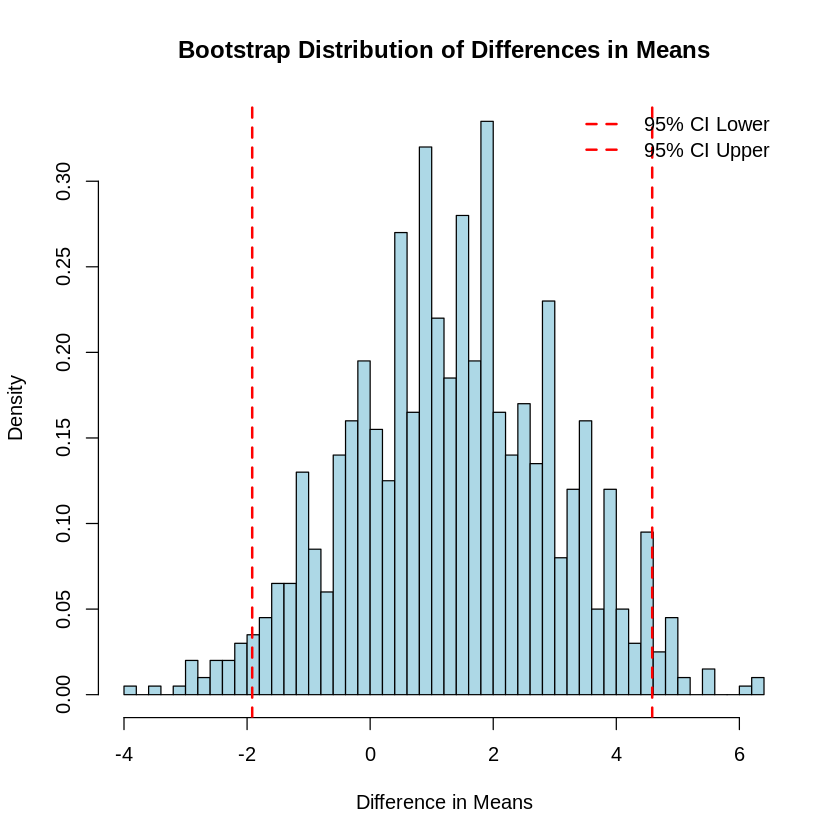

NULL

Sample Median: 33.5



Sign Test

Null Hypothesis: Median = 30

Assumptions: None

P-value: 0.77441, ACCEPT the hypothesis that the data are drawn from a population with median = 30 at significance level 0.05.

95% Confidence Interval for the median: [28.1064, 37]



Wilcoxon Signed-Rank Test

Null Hypothesis: Median = 30

Assumptions: Symmetric distribution of differences

P-value: 0.19485, ACCEPT the hypothesis that the data are drawn from a population with median = 30 at significance level 0.05.

95% Confidence Interval: [28.5001, 36.5]

The assumption of 0 skewness (symmetry) is ACCEPTABLE (skewness value is -0.389), suggesting the data are symmetrically distributed around the median.

Symmetry around the hypothesized median is ACCEPTED based on the Mann-Whitney U test at significance level 0.05 (p-value: 0.06015).



Bootstrap Test

Assumptions: None

Null hypothesis:  Mean = 30

P-value:  0.124400, so ACCEPT null hypothesis at significance level 0.05

95 percent bootstrap c

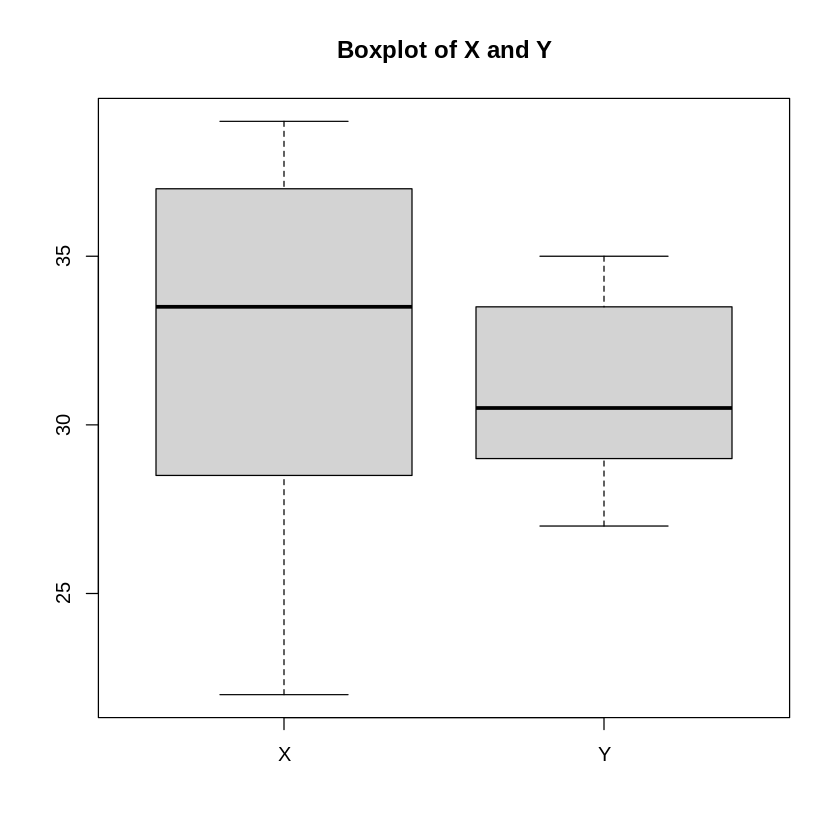



t-Test

Null Hypothesis: Mean = 30

Assumptions: Normal distribution

P-value: 0.16727, ACCEPT the hypothesis that the data are drawn from a population with mean = 30 at significance level 0.05.

95% Confidence Interval: [28.8603, 35.8064]



The hypothesis of a normal distribution is ACCEPTABLE at significance level 0.05 (p-value: 0.312 in a Shapiro-Wilks test).




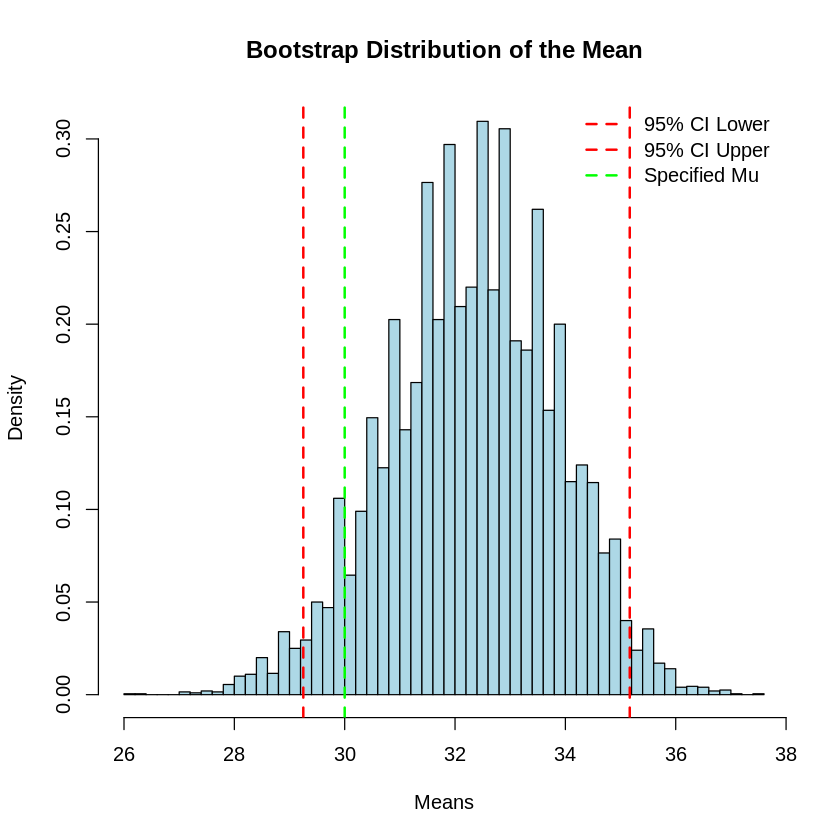

NULL

Sample Estimate:

Mean of Differences:  1.333333 



Wilcoxon Signed-Rank Test

Null Hypothesis: The median of differences is zero

P-value: 0.5044109 

ACCEPT the null hypothesis: no significant difference in the median of differences



Paired t-test

Null Hypothesis: The mean of differences is zero

P-value: 0.4974764 

95% Confidence Interval for the mean of differences: -2.849182 5.515849 

ACCEPT the null hypothesis: no significant difference in the mean of differences



Bootstrap Test for Mean of Differences

95% Confidence Interval for the mean of differences: -2.333333 4.752083 




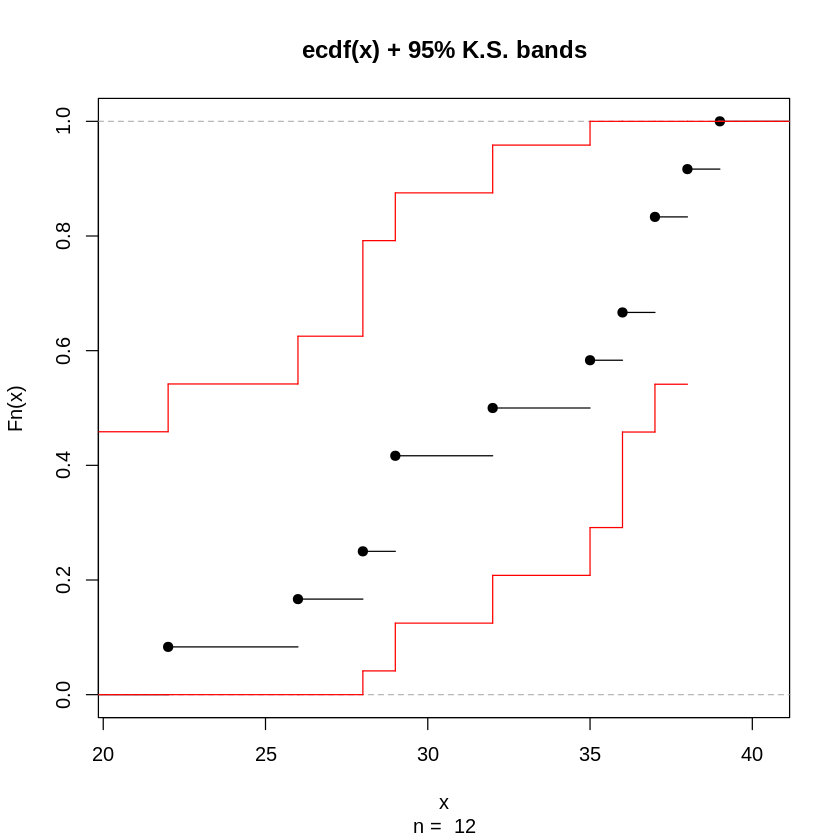

NULL

Sample Estimates:

Mean of X:  31 

Mean of Y:  32.33333 



Estimated Difference in Medians: -3 

Estimated Difference in Means: -1.333333 



Mann-Whitney U Test

Null Hypothesis: Difference in Medians =  0 

P-value: 0.4172987 

ACCEPT the null hypothesis: no significant difference in medians from  0 



Two-sample t-test

Null Hypothesis: Difference in Means =  0 

P-value: 0.4565331 

95% Confidence Interval for the difference in means: -5.041373 2.374706 

ACCEPT the null hypothesis: no significant difference in means from  0 



Bootstrap Test for Difference in Means

95% Confidence Interval for the difference in means: -4.333333 1.916667 




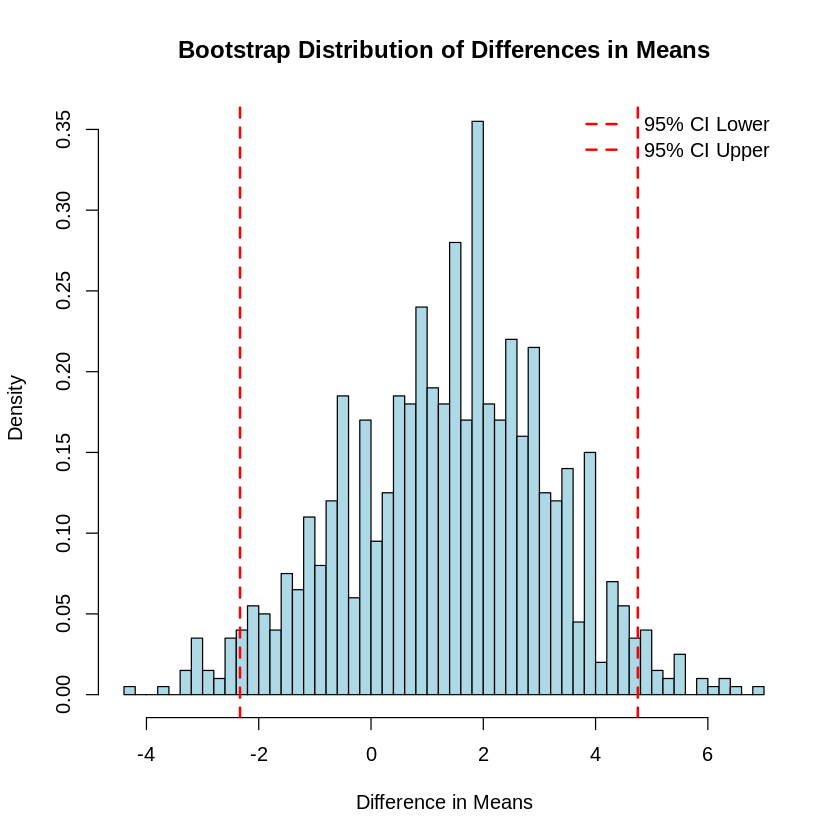

Kolmogorov-Smirnov Test

Null Hypothesis: The two samples are drawn from the same distribution

P-value: 0.2265609 

ACCEPT the null hypothesis: no significant evidence the samples are from different distributions.




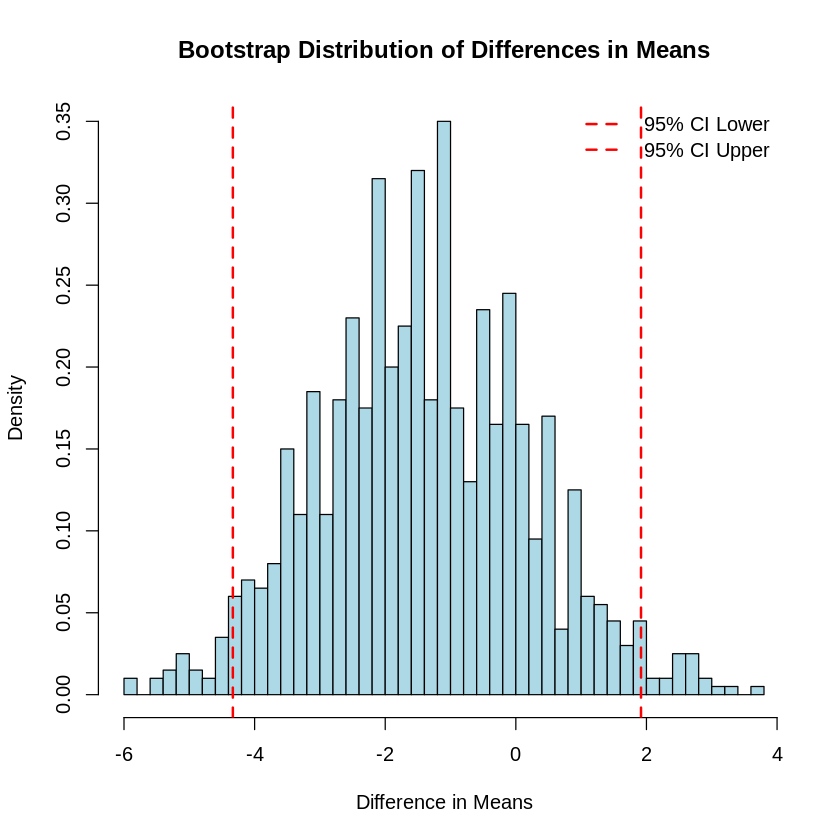

NULL

NULL

Sample Estimates:

Mean of X:  31 

Mean of Y:  32.33333 



Estimated Difference in Medians: -3 

Estimated Difference in Means: -1.333333 



Mann-Whitney U Test

Null Hypothesis: Difference in Medians =  0 

P-value: 0.4172987 

ACCEPT the null hypothesis: no significant difference in medians from  0 



Two-sample t-test

Null Hypothesis: Difference in Means =  0 

P-value: 0.4565331 

95% Confidence Interval for the difference in means: -5.041373 2.374706 

ACCEPT the null hypothesis: no significant difference in means from  0 



Bootstrap Test for Difference in Means

95% Confidence Interval for the difference in means: -4.416667 1.916667 




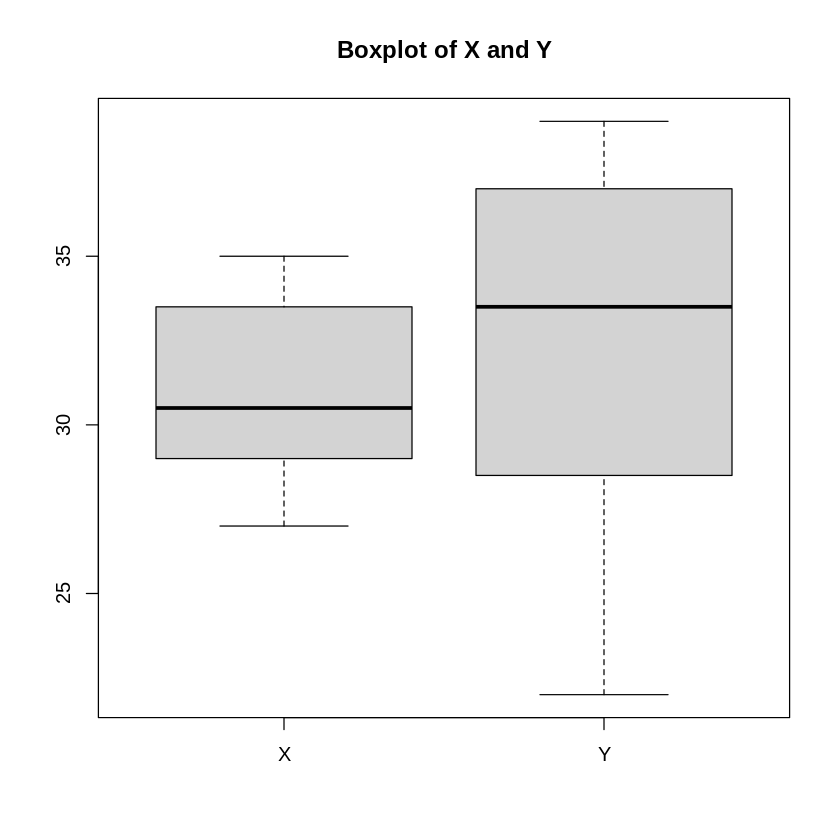

Kolmogorov-Smirnov Test

Null Hypothesis: The two samples are drawn from the same distribution

P-value: 0.2265609 

ACCEPT the null hypothesis: no significant evidence the samples are from different distributions.




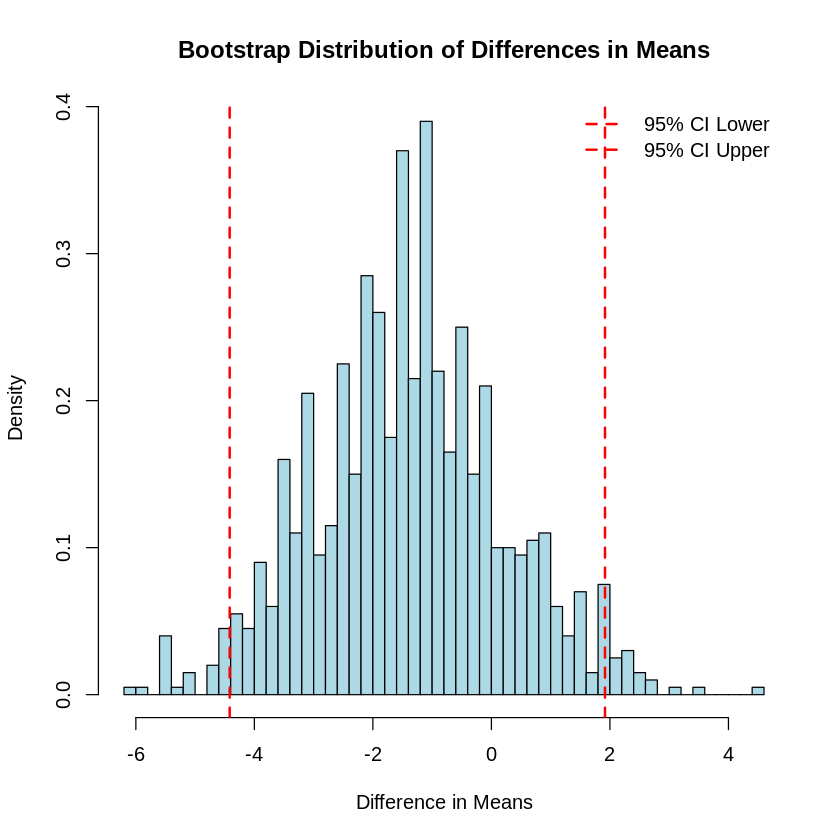

NULL

NULL

[1] "Results saved to test_results.json"


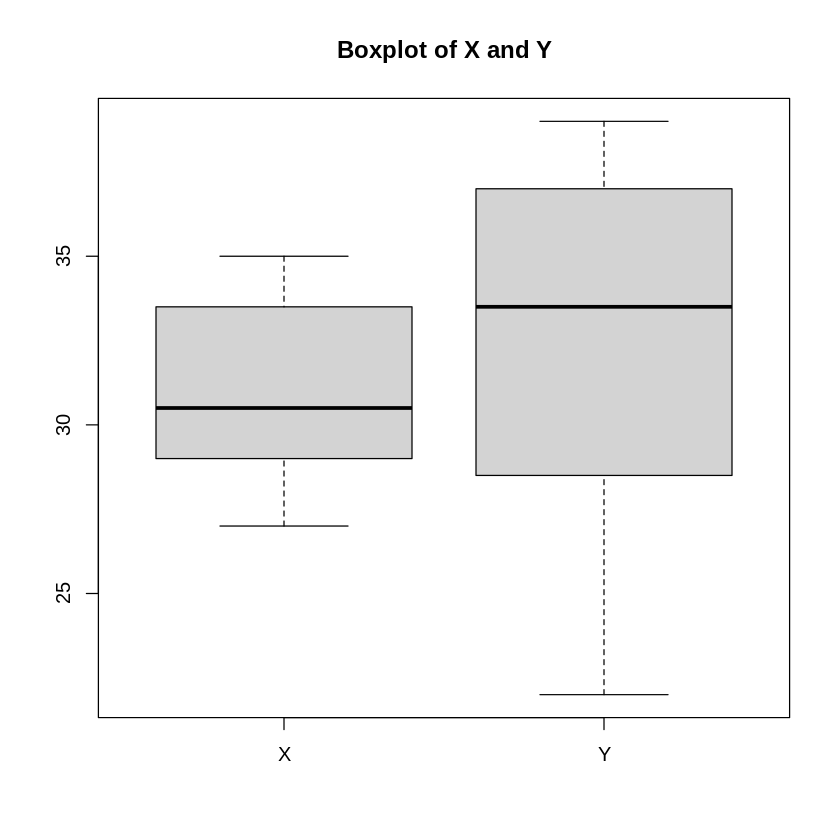

In [40]:
library(jsonlite)

# Function to save results as JSON
save_results_json <- function(results, filename) {
  write_json(results, filename)
  print(paste("Results saved to", filename))
}


# Example usage
test_results <- list(
  list(test_type = 'one_sample', statistic = 2.45, p_value = 0.03, interpretation = 'Reject null hypothesis'),
  list(test_type = 'two_sample', statistic = 1.25, p_value = 0.15, interpretation = 'Fail to reject null hypothesis')
)

# Example usage:

df <- data.frame(x = c(28, 29, 35, 37, 32, 26, 37, 39, 22, 29, 36, 38), y = c(30, 32, 34, 29, 31, 28, 30, 27, 33, 35, 29, 34))

cat.test(df$x, df$y)
cat.test(df$x, 30)
cat.test(df$x, df$y, paired = TRUE)
cat.test(x ~ y, df)
cat.test(df, x ~ y)

save_results_json(test_results, 'test_results.json')



In [41]:
library(httr)
library(jsonlite)

# Function to interpret results using OpenAI's API

get_interpretation <- function(test_results) {
  api_key <- Sys.getenv("OPENAI_API_KEY")
  endpoint <- "https://api.openai.com/v1/chat/completions"

  message_content <- paste("Please interpret these results:",
                           test_results$test_type,
                           "with statistic", test_results$statistic,
                           "and p-value", test_results$p_value)

  json_data <- toJSON(list(
    model = "gpt-4",
    messages = list(list(role = "user", content = message_content)),
    max_tokens = 500
  ), auto_unbox = TRUE)

  response <- httr::POST(
    url = endpoint,
    body = json_data,
    httr::add_headers(`Content-Type` = "application/json",
                      `Authorization` = paste("Bearer", api_key)),
    encode = "raw"
  )

  content <- httr::content(response, "parsed", encoding = "UTF-8")
  interpretation <- content$choices[[1]]$message$content
  return(interpretation)
}

# Make sure to set your API key in your environment or directly in the script
Sys.setenv(OPENAI_API_KEY = "APIS")


# Get the interpretation
interpretation_one_sample <- get_interpretation(test_results_one_sample)
print(interpretation_one_sample)


[1] "The statistic mentioned (0.19485) in this calculation could be any type of statistical value (like t-value, chi-square, etc). However, given that it's linked with a p-value, it's typically used to determine statistical significance in hypothesis testing\n\nThe p-value (0.77441) is quite large. In most analyses, a p-value of less than 0.05 is considered statistically significant. Here with a p-value of 0.77441, it implies that the results observed could quite likely occur by chance if the null hypothesis is true. Therefore, we fail to reject the null hypothesis; in other words, the findings are not statistically significant.\n\nThe statistic does not have a universal interpretation without additional context, but it is generally used to compare to a critical value to determine significance, which appears to not be the case here due to the large p-value.\n\nNote that without the specific context or understanding what 'china' represents in the analysis (could be a variable, could be 

In [28]:
library(jsonlite)

# Function to save results as JSON
save_results_json <- function(results, filename) {
  write_json(results, filename)
  print(paste("Results saved to", filename))
}


# # Example usage
# test_results <- list(
#   list(test_type = 'one_sample', statistic = 2.45, p_value = 0.03, interpretation = 'Reject null hypothesis'),
#   list(test_type = 'two_sample', statistic = 1.25, p_value = 0.15, interpretation = 'Fail to reject null hypothesis')
# )

# # Example usage:

# df <- data.frame(x = c(28, 29, 35, 37, 32, 26, 37, 39, 22, 29, 36, 38), y = c(30, 32, 34, 29, 31, 28, 30, 27, 33, 35, 29, 34))

# cat.test(df$x, df$y)
# cat.test(df$x, 30)
# cat.test(df$x, df$y, paired = TRUE)
# cat.test(x ~ y, df)
# cat.test(df, x ~ y)

save_results_json(test_results, 'test_results.json')



[1] "Results saved to test_results.json"
